In [2]:
! ls ../data/videos

20200703_手技 ⧸ Te-waza.mp4
20200810_腰技 ⧸ Koshi-waza.mp4
20201026_足技 ⧸ Ashi-waza.mp4
20201116_真捨身技 ⧸ Ma-sutemi-waza.mp4
20210115_横捨身技 ⧸ Yoko-sutemi-waza.mp4
20210329_抑込技 ⧸ Osaekomi-waza.mp4
20210514_絞技 ⧸ Shime-waza.mp4
20210621_関節技 ⧸ Kansetsu-waza.mp4


True


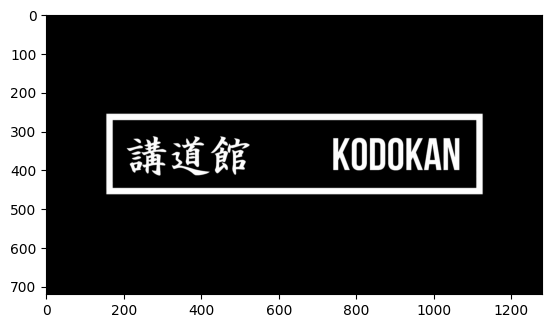

True

In [11]:
import cv2
import matplotlib.pyplot as plt
from pathlib import Path

videos = list(Path("../data/videos").glob("*.mp4"))
video = videos[0]
# load a video and display it
cap = cv2.VideoCapture(video.as_posix())
# let's skip the first 100 frames
for i in range(100):
    _ = cap.read()

ret, frame = cap.read()
print(ret)
plt.imshow(frame)
plt.show()

# return the stream to the first frame
cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

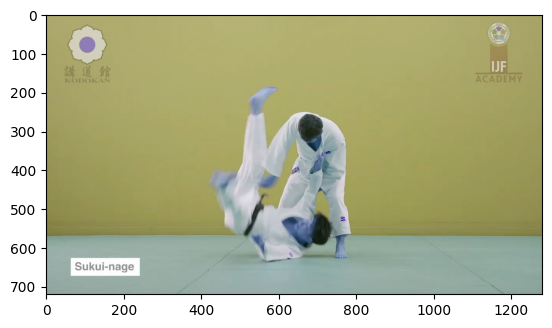

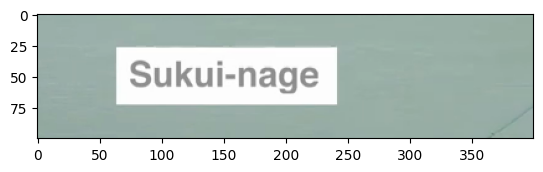

(100, 400, 3)


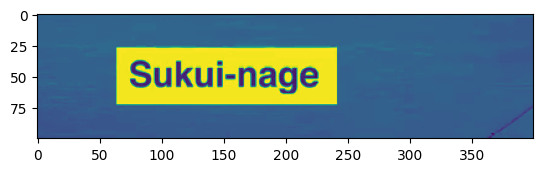

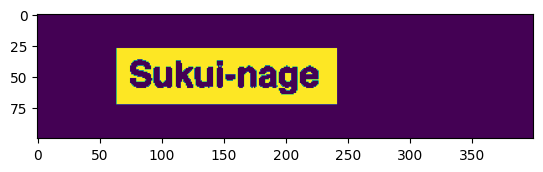

In [122]:
import numpy as np

# lets try to find a frame with throw names in the bottom left

cap.set(cv2.CAP_PROP_POS_FRAMES, 15 * 60)
ret, frame = cap.read()
plt.imshow(frame)
plt.show()

# let's get the bottom left corner
subset = frame[600:700, :400]
plt.imshow(subset)
plt.show()

# how many pixels are pretty close to white?
# 0.9 is pretty close to white
print(subset.shape)

# normalize the pixel distances to be grayscale between 0 and 1
X = cv2.cvtColor(subset, cv2.COLOR_BGR2GRAY)
dist = X / 255
plt.imshow(dist)
plt.show()
# what threshold should we use?
plt.imshow((dist > 0.95).astype(int))
plt.show()

In [65]:
# now lets stream this subset and see if we can calculate discontinuities
# we'll do a simple absolute difference between pixel values
def get_normalized(img):
    subset = img[600:700, :400]
    gray = cv2.cvtColor(subset, cv2.COLOR_BGR2GRAY)
    return gray / 255


diffs = []
prev = None
cap = cv2.VideoCapture(video.as_posix())
while True:
    ret, frame = cap.read()
    if not ret:
        break
    subset = get_normalized(frame)
    if prev is None:
        prev = subset
        continue
    # a simple difference of the current and next frame isn't sufficient here.
    # we'll want to find the box in the frame and match on that
    diff = np.abs((subset > 0.9).astype(int) - (prev > 0.9).astype(int)).sum()
    diffs.append(diff)
    prev = subset

len(diffs)

2179

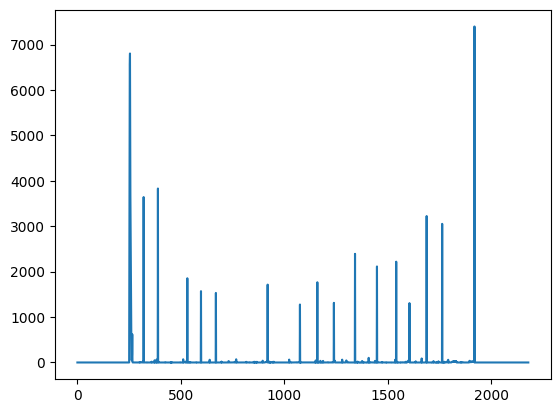

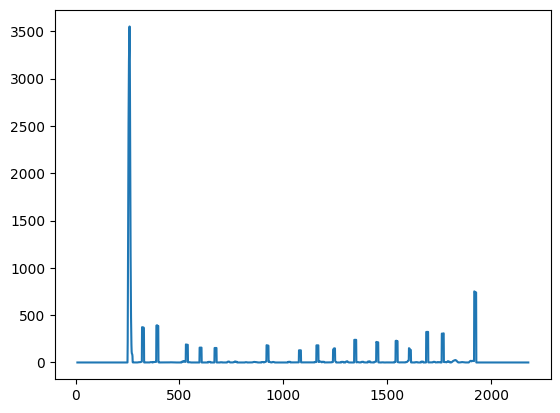

In [106]:
import pandas as pd

plt.plot(diffs)
plt.show()

# rolling sum of the last 10 diffs
plt.plot(pd.Series(diffs).rolling(10).mean())
plt.show()

In [107]:
# find the discontinuities using mean absolute deviation

print(len(diffs), len(pd.Series(diffs).rolling(10).mean()))

2179 2179


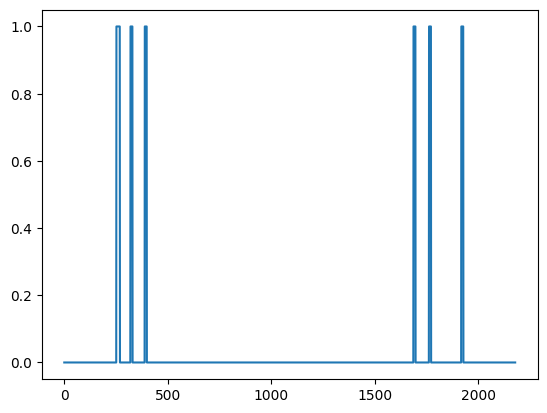

In [120]:
from scipy.stats import median_abs_deviation

y = pd.Series(diffs).rolling(10).mean().fillna(0)
z_scores = (y - y.mean()) / y.std()

plt.plot(z_scores > 1)
plt.show()